In [1]:
import os
import json
import sys
import numpy as np
import soundfile
from torch.utils.data import Dataset
from tqdm import tqdm

from dataset import MAESTRO

In [2]:
dataset = MAESTRO(path='/data/MAESTRO', groups=['train'], sequence_length=320000)

Loading group train: 100%|██████████| 967/967 [00:24<00:00, 40.24it/s]


In [4]:
# repopulate maestro dataset with emotion labels
import IPython.display as ipd
from tqdm import tqdm

energy = []
valence = []
cls = []

counter = 0
for i in tqdm(range(len(dataset))):
    ds = dataset[i]
    if "emotion_dict" in ds:
        audio = ds["audio"]
        energy.append(ds["emotion_dict"]["res"]["energy"])
        valence.append(ds["emotion_dict"]["res"]["valence"])
        cls.append(ds["emotion_dict"]["res"]["emotion_class"])
#         if ds["emotion_dict"]["res"]["energy"] > 0.25 and ds["emotion_dict"]["res"]["valence"] > 0.25:
#             ipd.display(ipd.Audio(audio.cpu().numpy(), rate=16000))
        counter += 1


100%|██████████| 967/967 [00:14<00:00, 66.30it/s] 


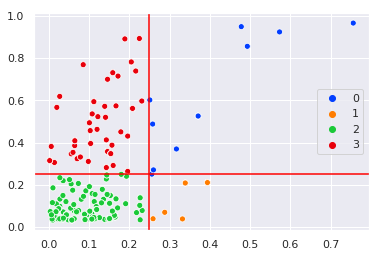

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

palette = sns.color_palette("bright", 4)
sns.scatterplot(energy, valence, palette=palette, hue=cls)
plt.axvline(0.25, color='red')
plt.axhline(0.25, color='red')
plt.show()

In [ ]:
from IPython.display import Audio
ds = dataset[0]
Audio(ds['audio'].cpu().numpy(), rate=16000)

In [ ]:
import pretty_midi

def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [ ]:
pr = np.pad(ds['onset'].cpu().numpy(), ((0, 0), (38, 2)), "constant", constant_values=0)
pr[pr > 0] = 110
print(pr.shape)
print(pr.T.shape)
print(np.amin(pr), np.amax(pr))
pm = piano_roll_to_pretty_midi(pr.T)
pm.instruments[0].program = 1
x = pm.fluidsynth()
Audio(x, rate=16000)

In [ ]:
from nnAudio import Spectrogram
from scipy.io import wavfile
import torch
import time

start = time.time()
x = ds['audio']
print(x)
spec_layer = Spectrogram.STFT(n_fft=2048, freq_bins=None, hop_length=512, 
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect', 
                              fmin=50,fmax=11025, sr=16000) # Initializing the model
                              
spec = spec_layer(x) # Feed-forward your waveform to get the spectrogram   
print(spec.shape)

In [ ]:
!pip install nnAudio

In [ ]:
!pip install pyfluidsynth

In [ ]:
!pip install mir_eval

In [ ]:
!pip install seaborn